## Backpropagation

In [4]:
%matplotlib inline
import numpy as np
from pprint import pprint
from random import random
from matplotlib import pyplot as plt
plt.style.use('seaborn-pastel')

### Neural Networks - Activation Function
The activation function is one of the most important parts of a Neural Network. It works by taking an input value, which might be a scalar or a vector (numpy array), and returns the output depending on whether the input has crossed a certain threshold. This threshold value is determined by the particular function used.  
Typical activation functions used for Neural networks are:  
- Sigmoid Function  
- Hyperbolic Tangent Function
- Rectified Linear Unit (ReLU) 

In [5]:
def actv_fn(x, fn='sigmoid', derivative=False):
    if not derivative:
        if fn == 'sigmoid': 
            return 1/(1+np.exp(-x))
        elif fn == 'relu':
            if x>0:
                return x
            else:
                return 0.01*x # leaky relu
        elif fn == 'tanh':
            return (2/(1+np.exp(-2*x)))-1
        else:
            return None
    else:
        if fn == 'sigmoid':
            # input x is value of sigmoid(x)
            return x*(1-x)
        elif fn == 'relu':
            # input x is value of relu(x) i.e x or 0.01x
            if x: 
                return 1
            return 0.01
        elif fn == 'tanh':
            # input x is value of tanh(x)
            return 1 - x*x
        else:
            return None
    
def error(y, yhat):
    return np.sum((np.subtract(yhat, y)**2)/2)

The training process of a Neural network involves two steps, a forward pass and a backward pass, both of which use the activation function. In the backward pass, or backpropagation step, we are more concerned with the derivative of the activation function, the reason for which is explained later in this tutorial. Taking the derivative of any function at a point simply means finding the slope of the function at that point. It is easier to visualize the derivative when the function is in the form of a graph, as shown below. 

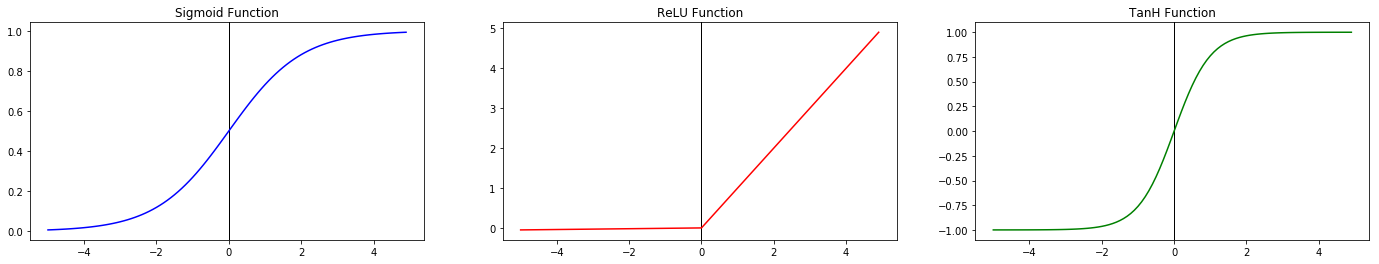

In [7]:
x = np.arange(-5, 5, 0.1)
fig = plt.figure(figsize=(24, 4))

y1 = [actv_fn(i, fn='sigmoid') for i in x]
ax1 = fig.add_subplot(131)
ax1.set_title('Sigmoid Function')
ax1.axvline(0, linewidth=1, color='black')
ax1.plot(x, y1, 'b-')

y2 = [actv_fn(i, fn='relu') for i in x]
ax2 = fig.add_subplot(132)
ax2.set_title('ReLU Function')
ax2.axvline(0, linewidth=1, color='black')
ax2.plot(x, y2, 'r-')

y3 = [actv_fn(i, fn='tanh') for i in x]
ax3 = fig.add_subplot(133)
ax3.set_title('TanH Function')
ax3.axvline(0, linewidth=1, color='black')
ax3.plot(x, y3, 'g-')

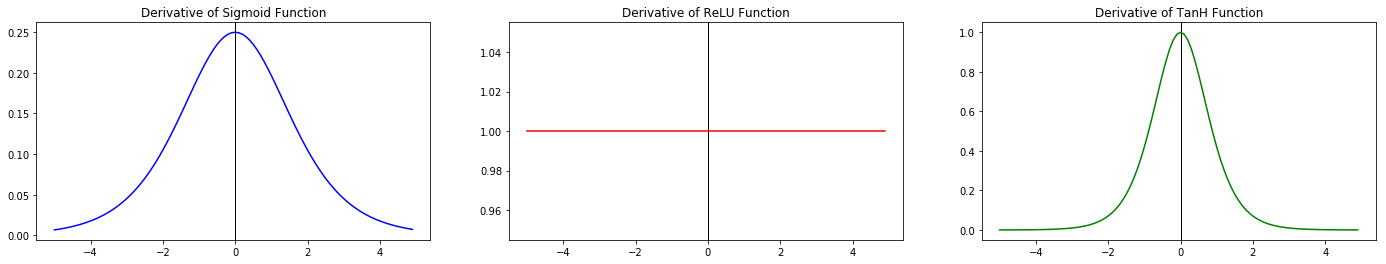

In [8]:
x = np.arange(-5, 5, 0.1)
fig = plt.figure(figsize=(24, 4))

y1 = [actv_fn(i, fn='sigmoid') for i in x]
y1 = [actv_fn(i, fn='sigmoid', derivative=True) for i in y1]
ax1 = fig.add_subplot(131)
ax1.set_title('Derivative of Sigmoid Function')
ax1.axvline(0, linewidth=1, color='black')
ax1.plot(x, y1, 'b-')

y2 = [actv_fn(i, fn='relu') for i in x]
y2 = [actv_fn(i, fn='relu', derivative=True) for i in y2]
ax2 = fig.add_subplot(132)
ax2.set_title('Derivative of ReLU Function')
ax2.axvline(0, linewidth=1, color='black')
ax2.plot(x, y2, 'r-')

y3 = [actv_fn(i, fn='tanh') for i in x]
y3 = [actv_fn(i, fn='tanh', derivative=True) for i in y3]
ax3 = fig.add_subplot(133)
ax3.set_title('Derivative of TanH Function')
ax3.axvline(0, linewidth=1, color='black')
ax3.plot(x, y3, 'g-')

In [12]:
class NeuralNet:
    def __init__(self, data, labels, weights, biases, function='sigmoid', learning_rate=0.05, tolerance=1e-5, max_iter=10000):
        self.x = data
        self.y = labels
        self.wts = weights
        self.b = biases
        self.fn = function
        self.eta = learning_rate
        self.tol = tolerance
        self.iterations = max_iter
        self.activations = []
        self.ERRORS = []
        self.show_params()
    
    def show_params(self):
        print("Activation Function :", self.fn)
        print("Learning Rate :", self.eta)
        print("Tolerance :", self.tol)
        print("Maximum Iterations :", self.iterations)
        print("Number of layers :", self.wts.ndim)
        for i in range(self.wts.ndim):
            print("----------------------")
            if i==0:
                print("Input Layer :", self.wts.shape[i], "units")
            elif i==self.wts.ndim-1:
                print("Output Layer :", self.wts.shape[i], "units")
                print("----------------------")
                break
            else:
                print("Layer", i, " (Hidden) :", self.wts.shape[i], "units")
            print("Weights to next layer :")
            pprint(self.wts[i])
        print("")
    
        
    def train(self):
        for i in range(self.iterations):
            if len(self.ERRORS)>1:
                err_delta = self.ERRORS[-2]-self.ERRORS[-1]
                #print err_delta
                if err_delta<self.tol:
                    print("Converged at step", i-1, "with error", self.ERRORS[-1])
                    break
            self.frontprop()
            self.backprop()
    
    def frontprop(self, mode='train', pred_input=None):
        #print "Original weights"
        #pprint(self.wts)
        #print ""
        print("Iteration", len(self.ERRORS))
        print("Starting frontprop pass")
        if mode == 'train':
            fp_input=self.x
        elif mode == 'predict':
            assert(pred_input is not None)
            fp_input = pred_input
        else:
            return None
        
        for j in range(self.wts.shape[0]):
            #print "weight arr index :", j
            #print "input"
            if j == 0:
                inp = fp_input.copy()
                #try:
                #    np.dot(self.wts[j][0], inp)
                #except ValueError, e:
                #    print "INCOMPATIBLE DIMS"
                #print inp, "\n"
            else:
                inp = self.activations[-1]
                #print inp, "\n"
            outs = []
            for k in range(self.wts.shape[j]):
                #print "NET CALC : input", inp, ", weights", self.wts[j][k], ", biases", self.b[j]
                #print "W: len", len(self.wts), ":::",self.wts.shape,":::",self.wts[j].shape,":::",self.wts[j][k].shape, "X:", inp.shape, "b:", self.b.shape
                net = np.dot(self.wts[j][k], inp)+self.b[j]
                #print "NET :"
                #pprint(net)
                #print "OUT :"
                out = actv_fn(net, fn=self.fn)
                #pprint(out)
                outs.append(out)
                #print "----------"
            #print outs
            self.activations.append(np.array(outs))
            #print "----------------------------"
        final = self.activations[-1]
        final = np.array(final)
        total_error = 0.0
        for l in range(len(final)):
            #print l, final[l], self.y[l]
            err = error(final[l], self.y[l])
            total_error += err
        if mode == 'predict':
            return final
        print("total error", total_error)
        self.ERRORS.append(total_error)
    
    def backprop(self):
        print("Starting backprop pass")
        #print "Prev layers", len(self.activations)
        for j in range(self.wts.shape[0]):
            #print "Prev layers j", len(self.activations[j])
            for k in range(self.wts.shape[j]):
                p1 = self.activations[k][j]-self.y[j]
                #print "out_o - target", p1
                p2 = actv_fn(self.activations[k][j], fn=self.fn, derivative=True)
                #print "out_o*(1-out_o)", p2
                p3 = self.activations[k-1][j]
                #print "out_h", p3
                delta = -1*p1*p2*p3
                #print "delta", delta
                #print "change", self.eta*delta
                for l in range(len(self.wts[k][j])):
                    new_w = self.wts[k][j][l] + self.eta*delta # learning step
                    self.wts[k][j][l] = new_w
                #print ""
        #print "Modified Weights"
        #pprint(self.wts)
        print("\n====================================================\n")
                
    def predict(self, input_x):
        return self.frontprop(mode='predict', pred_input=input_x)
    
    def plot_loss(self):
        plt.figure(figsize=(10,6))
        plt.xlim(0, 1.2*len(self.ERRORS))
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training Loss over time')
        plt.plot([i for i in range(len(self.ERRORS))], self.ERRORS, 'b-')
        plt.show()

Activation Function : sigmoid
Learning Rate : 0.5
Tolerance : 1e-05
Maximum Iterations : 1000
Number of layers : 3
----------------------
Input Layer : 2 units
Weights to next layer :
array([[0.15, 0.2 ],
       [0.25, 0.3 ]])
----------------------
Layer 1  (Hidden) : 2 units
Weights to next layer :
array([[0.4 , 0.45],
       [0.5 , 0.55]])
----------------------
Output Layer : 2 units
----------------------

Iteration 0
Starting frontprop pass
total error 0.2983711087600027
Starting backprop pass


Iteration 1
Starting frontprop pass
total error 0.29103631657807943
Starting backprop pass


Iteration 2
Starting frontprop pass
total error 0.2836435570431649
Starting backprop pass


Iteration 3
Starting frontprop pass
total error 0.27620148507047654
Starting backprop pass


Iteration 4
Starting frontprop pass
total error 0.26871916564074066
Starting backprop pass


Iteration 5
Starting frontprop pass
total error 0.26120603932022785
Starting backprop pass


Iteration 6
Starting frontpro

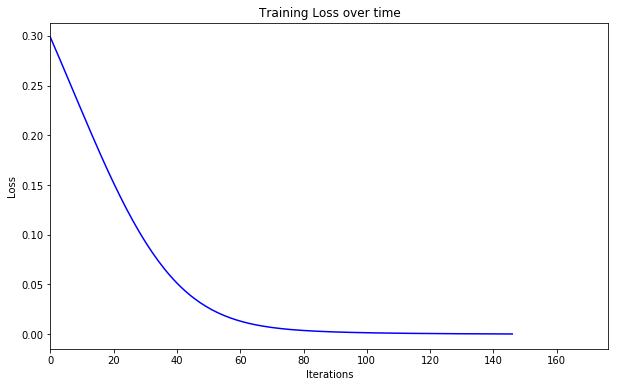

In [13]:
X = np.array([[0.05], [0.10]])
Y = np.array([[0.01], [0.99]])
W = np.array([
                [[0.15, 0.20],[0.25, 0.30]], #layer 0->1
                [[0.40, 0.45],[0.50, 0.55]]  #layer 1->2
               ])
B = np.array([[0.35], [0.6]])

NN = NeuralNet(X, Y, W, B, 'sigmoid', 0.5, 1e-5, 1000)
NN.train()
NN.plot_loss()

In [15]:
print(NN.activations[-1])

[[0.00125097]
 [0.96966375]]


### Credits

Props to Matt Mazur, whose excellent article on explaining backprop is the basis for this notebook. Actually working through the derivations helps to get a feel for the underlying intuition, and that article was an invaluable resource in understanding the concept of backprop.  
Link to article : [A Step by Step Backpropagation Example](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/)